In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import time

seed = 0
np.random.seed(seed)
import tensorflow as tf
tf.random.set_seed(seed)
import os

2022-07-12 14:23:15.266682: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-07-12 14:23:15.310520: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-12 14:23:15.310533: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [3]:
mpl.rcParams.update({'font.size': 16})

# PATHS
PLOT_PATH = 'Plots/'
DATA_PATH = 'Data/'

In [4]:
LHCfreq = 11245.6 
nCollBunch = 2760

minbias_rate = LHCfreq * nCollBunch /1e3 # in kHz

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from callbacks import all_callbacks

In [6]:
def plot_training(history):
    f,axs = plt.subplots(2,1,figsize = (10,10), sharex = True)
    plt.subplots_adjust(wspace=0, hspace=0)

    columns = ['accuracy', 'loss', 'val_accuracy', 'val_loss']

    ax = axs[0]

    ax.plot(history.history['accuracy'], label= 'accuracy')
    ax.plot(history.history['val_accuracy'], label= 'val_accuracy')    
    ax.legend()
    #ax.set_ylim(0.99,1)

    ax = axs[1]

    ax.plot(history.history['loss'], label= 'loss')
    ax.plot(history.history['val_loss'], label= 'val_loss') 
  
    ax.legend()
    #ax.set_ylim(0,0.4)
    #axs[0].legend(title = "NN size wrt reference", ncol = 1,
                  #bbox_to_anchor=(0.1, 1.2),
    #               fancybox=True, shadow=True
                 #)

    axs[-1].set_xlabel("Epoch")

## Prepare dataset

## Signals

In [7]:
# filter variables for training:
var_names = [ 'electron0_Et', 'electron0_Eta', 'electron0_Phi',
              'electron1_Et', 'electron1_Eta', 'electron1_Phi', 'jet0_Et', 'jet0_Eta',
              'jet0_Phi', 'jet1_Et', 'jet1_Eta', 'jet1_Phi', 'jet2_Et', 'jet2_Eta',
              'jet2_Phi', 'jet3_Et', 'jet3_Eta', 'jet3_Phi', 'met_Et', 'met_Phi',
              'muon0_Eta', 'muon0_Phi', 'muon0_Pt', 'muon1_Eta', 'muon1_Phi',
              'muon1_Pt']

In [8]:
# filter variables for training:
var_names_small = [ 'electron0_Et', 'electron0_Eta', 'electron1_Et', 'electron1_Eta', 
                   'jet0_Et', 'jet0_Eta', 'jet1_Et', 'jet1_Eta', 'jet2_Et', 'jet2_Eta',
                   'jet3_Et', 'jet3_Eta', 'met_Et', 'muon0_Eta', 'muon0_Pt', 'muon1_Eta', 'muon1_Pt']

In [9]:
# df_ttbar = pd.read_hdf("ttbar_full2.h5")
df_ttbar = pd.read_hdf( DATA_PATH + "ttbar_l1tdata_all.h5", key = "l1tdata")
# genlep
# df_genlep = pd.read_hdf("p2MenuTuple/ttbar_geninfo_full.h5", key = "geninfo")
df_genlep = pd.read_hdf( DATA_PATH + "ttbar_geninfo_test.h5", key = "geninfo")
# join
# df_ttbar = df_ttbar.join(df_genlep)
df_HH = pd.read_hdf( DATA_PATH + "hh_to_2b2tau_l1tdata_cleanLep_v10.h5", key = "l1tdata")
df_genlep_HH = pd.read_hdf( DATA_PATH + "hh_to_2b2tau_v10_geninfo_wBquarks.h5", key = "geninfo")

In [10]:
df_ttbar

HT       MHTEt  electron0_Et  electron0_Eta  electron0_Phi  \
0       221.144827  121.020711     23.448750       -0.04365      -2.783797   
1        47.167639   47.167639      0.000000        0.00000       0.000000   
2       209.029257   60.343236     16.585575       -0.53253      -1.823866   
3       127.333368   57.779517      0.000000        0.00000       0.000000   
4       371.741640   67.383841     34.471252        0.63729       1.195554   
...            ...         ...           ...            ...            ...   
297837   58.076285   58.076285     24.141162        1.64991      -0.496086   
297838  333.292074   28.171070      7.035875       -0.23571      -0.287976   
297839  203.496621  102.932871      0.000000        0.00000       0.000000   
297840  315.829993  120.506961     14.131599       -1.47537       2.679084   
297841  221.798842  107.657141      0.000000        0.00000       0.000000   

        electron1_Et  electron1_Eta  electron1_Phi     jet0_Et  jet0_Eta  ...  \
0         100.931244      -0.864270      -1.684239  115.292523   -0.8750  ...   
1           0.000000       0.000000       0.000000   47.167639    1.9585  ...   
2          12.926375      -0.497610      -2.085665  116.415167   -0.5415  ...   
3           0.000000       0.000000       0.000000   52.060351    0.8750  ...   
4           8.274750       0.602370       1.125741  134.808732    0.6250  ...   
...              ...            ...            ...         ...       ...  ...   
297837     23.994471       1.649910      -0.496086   58.076285   -0.5415  ...   
297838     20.077276       0.427770      -1.911132  167.911536    1.6250  ...   
297839      0.000000       0.000000       0.000000  102.654375    2.2915  ...   
297840     38.975671      -2.328322      -2.097395  171.136381   -1.5415  ...   
297841      0.000000       0.000000       0.000000   98.589508    1.2085  ...   

        jet3_Eta  jet3_Phi      met_Et   met_Phi  muon0_Eta  muon0_Phi  \
0        -1.7915  0.654498  103.871000  1.029963   2.296222  -0.542770   
1         1.0415  2.487094   41.979614 -0.880399   1.948953   2.890523   
2        -0.2085 -2.312561   61.107336  1.324469   2.253302   2.916581   
3         1.2085  0.741765   78.171611 -2.727065   1.037795  -1.535014   
4         0.2915  1.876229   68.295750 -1.662814   1.572923  -0.212757   
...          ...       ...         ...       ...        ...        ...   
297837    0.0000  0.000000   57.681057 -3.039365  -0.484703  -2.988967   
297838   -0.4585 -2.138028   13.539036 -2.446669   1.336508  -0.637478   
297839    2.1250 -2.138028   89.044165 -2.130118   2.304363   0.775936   
297840    0.9585 -3.097959  114.862633  0.299925  -0.938206   0.158403   
297841   -0.3750  0.392699   74.960062 -3.130479   2.325001   1.516675   

         muon0_Pt  muon1_Eta  muon1_Phi   muon1_Pt  
0        3.629292   2.296222  -0.542770   3.629292  
1       39.229697   2.188374  -2.129283   2.363637  
2        1.964261  -1.949498  -0.338040   1.986403  
3        6.258176   0.870282  -1.385396  32.652953  
4        1.978262  -1.970538   1.413059   2.170056  
...           ...        ...        ...        ...  
297837  22.027788  -0.484703  -2.988967  22.027788  
297838   3.246200   0.000000   0.000000   0.000000  
297839  93.294161  -1.521223   0.239457   2.729106  
297840   4.604730   1.594461   2.707390   2.056308  
297841   2.713100   2.325001   1.516675   2.713100  

[297842 rows x 28 columns]

In [11]:
df_HH

HT        MHTEt  electron0_Et  electron0_Eta  electron0_Phi  \
0       261.786268    34.286188     16.305721       2.012353       2.970391   
1       212.518155   107.100004     24.281250       0.532530       1.317727   
2       357.186256    55.853028     86.457146      -0.811890      -1.055921   
3       123.122584    19.234078      0.000000       0.000000       0.000000   
4       171.000976    60.967149     26.085001       0.497610      -0.270523   
...            ...          ...           ...            ...            ...   
19995   620.189815    63.468628      5.399625       0.549990      -3.132863   
19996  1965.113946  1231.108910      0.000000       0.000000       0.000000   
19997   332.823577   233.897400      0.000000       0.000000       0.000000   
19998   512.806523    87.750705      0.000000       0.000000       0.000000   
19999   517.878708   120.375687      0.000000       0.000000       0.000000   

       electron1_Et  electron1_Eta  electron1_Phi      jet0_Et  jet0_Eta  ...  \
0           0.00000       0.000000        0.00000   132.315640    1.7085  ...   
1          18.57817       1.474282       -0.20725   140.142537    1.4585  ...   
2           0.00000       0.000000        0.00000   148.720703   -1.0415  ...   
3           0.00000       0.000000        0.00000    66.890865    1.7915  ...   
4           0.00000       0.000000        0.00000    95.667029    0.5415  ...   
...             ...            ...            ...          ...       ...  ...   
19995       0.00000       0.000000        0.00000   314.655961   -0.8750  ...   
19996       0.00000       0.000000        0.00000  1575.742391    0.9585  ...   
19997       0.00000       0.000000        0.00000   202.761292   -0.1250  ...   
19998       0.00000       0.000000        0.00000   255.876180    2.2085  ...   
19999       0.00000       0.000000        0.00000   262.529504    0.0415  ...   

       jet3_Eta  jet3_Phi       met_Et   met_Phi  muon0_Eta  muon0_Phi  \
0        1.7085  2.138028    55.190439  2.406593   1.810386   3.062711   
1       -2.3750 -3.097959    71.838579  2.858665   1.075351   1.822729   
2       -0.7085 -2.748894    30.242674 -2.999722  -1.850083  -2.120407   
3       -0.6250 -2.312561    44.510532  2.391780   0.708699  -1.669566   
4       -0.2085  2.574361    18.728684 -2.322295   0.770940  -2.150217   
...         ...       ...          ...       ...        ...        ...   
19995   -2.0415  2.138028    82.449402  2.858946  -1.401812   1.963965   
19996   -1.7085 -1.527163  1216.831586 -1.355211  -1.294465  -0.961671   
19997   -0.7085 -0.130900   211.978676  1.573874  -1.931910  -1.720494   
19998    0.0000  0.000000    86.514250  0.763341   0.000000   0.000000   
19999    1.9585 -1.439897   174.198547  2.627812  -2.145544  -2.981403   

        muon0_Pt  muon1_Eta  muon1_Phi   muon1_Pt  
0      47.853472  -2.370144   2.325748   2.809212  
1       4.726269  -1.979578  -0.579017   2.825657  
2       2.317263   0.000000   0.000000   0.000000  
3      42.053048  -2.268210  -0.917435   4.978478  
4      24.616418   0.770940  -2.150217  24.616418  
...          ...        ...        ...        ...  
19995   2.735158   0.000000   0.000000   0.000000  
19996   2.957380   1.928579  -2.569279   2.013787  
19997   5.324703  -1.478884   0.852845   4.808144  
19998   0.000000   0.000000   0.000000   0.000000  
19999   8.804127  -2.145544  -2.981403   8.804127  

[20000 rows x 28 columns]

In [12]:
df_genlep

genlep_Id   genlep_Pt  genlep_Eta  genlep_Phi  nGenEle  nGenMu  \
0            11.0   99.610176   -0.886203   -1.701490        1       0   
1           -15.0   70.477615    2.225950   -0.925727        0       1   
2             0.0    0.000000    0.000000    0.000000        0       0   
3           -15.0  101.383667    1.094607   -1.545349        0       1   
4             0.0    0.000000    0.000000    0.000000        0       0   
...           ...         ...         ...         ...      ...     ...   
297837       15.0   27.713539   -0.498630   -2.991030        0       0   
297838      -11.0  126.167229    1.595104    1.288866        1       0   
297839       13.0   90.085564    2.303661    0.775822        0       1   
297840      -11.0   29.326284   -2.330500   -2.079463        1       0   
297841        0.0    0.000000    0.000000    0.000000        0       0   

        nGenTau         Mtt  type  
0             0  410.979278  1ele  
1             1  388.885917  none  
2             0  449.754093   had  
3             1  372.798257  none  
4             0  366.071066   had  
...         ...         ...   ...  
297837        1  387.514240  none  
297838        0  606.206536  1ele  
297839        0  437.320730   1mu  
297840        0  555.078899  1ele  
297841        0  567.871380   had  

[297842 rows x 9 columns]

In [13]:
df_genlep_HH

genlep_id  genlep_pt  genlep_eta  genlep_phi  nGenEle  nGenMu  nGenTau  \
0             13  47.247818    1.813590    3.062721        0       1        0   
1             11  24.193069    0.508816    1.279513        1       0        0   
2              0   0.000000    0.000000    0.000000        0       0        0   
3             13  41.099880    0.708738   -1.669649        0       1        0   
4            -13  24.819557    0.773266   -2.150919        0       1        0   
...          ...        ...         ...         ...      ...     ...      ...   
19995         11   6.744641   -0.761602    2.096936        1       0        0   
19996          0   0.000000    0.000000    0.000000        0       0        0   
19997        -13   4.752907   -1.483295    0.852437        1       1        0   
19998          0   0.000000    0.000000    0.000000        0       0        0   
19999        -11   5.920336    0.249854   -2.877843        1       0        0   

           M  type  
0      345.0   1mu  
1      345.0  1ele  
2      345.0   had  
3      345.0   1mu  
4      345.0   1mu  
...      ...   ...  
19995  345.0  1ele  
19996  345.0   had  
19997  345.0  none  
19998  345.0   had  
19999  345.0  1ele  

[20000 rows x 9 columns]

In [14]:
df_bkg = pd.read_hdf( DATA_PATH + "minbias_v10full.h5", key = "array")
df_bkg = df_bkg[var_names]

df_bkg

electron0_Et  electron0_Eta  electron0_Phi  electron1_Et  \
0                0.0            0.0            0.0           0.0   
1                0.0            0.0            0.0           0.0   
2                0.0            0.0            0.0           0.0   
3                0.0            0.0            0.0           0.0   
4                0.0            0.0            0.0           0.0   
...              ...            ...            ...           ...   
993623           0.0            0.0            0.0           0.0   
993624           0.0            0.0            0.0           0.0   
993625           0.0            0.0            0.0           0.0   
993626           0.0            0.0            0.0           0.0   
993627           0.0            0.0            0.0           0.0   

        electron1_Eta  electron1_Phi    jet0_Et  jet0_Eta  jet0_Phi  \
0                 0.0            0.0  13.013841    0.8750  1.614430   
1                 0.0            0.0   0.000000    0.0000  0.000000   
2                 0.0            0.0  72.297753   -0.7085 -0.392699   
3                 0.0            0.0  41.133553   -1.2915 -2.574361   
4                 0.0            0.0   0.000000    0.0000  0.000000   
...               ...            ...        ...       ...       ...   
993623            0.0            0.0  27.522016   -1.3750 -1.614430   
993624            0.0            0.0  19.105943   -0.6250  3.010693   
993625            0.0            0.0  36.716617    2.1250  0.043633   
993626            0.0            0.0  24.974128   -2.3750 -0.218166   
993627            0.0            0.0  15.683347    0.9585  0.654498   

          jet1_Et  ...  jet3_Eta  jet3_Phi     met_Et   met_Phi  muon0_Eta  \
0        7.835610  ...    0.0000  0.000000  32.284280 -1.533995   1.914585   
1        0.000000  ...    0.0000  0.000000  16.451852 -0.399869   1.617819   
2       52.803383  ...    1.7085 -1.963495  30.077722  1.874108   2.156309   
3       38.040460  ...    0.0000  0.000000  31.654083  1.161586   2.022619   
4        0.000000  ...    0.0000  0.000000   7.384008 -2.707507   2.197844   
...           ...  ...       ...       ...        ...       ...        ...   
993623  17.372303  ...   -2.3750  1.178097  30.566487  2.314378  -1.959262   
993624  13.202146  ...    0.0000  0.000000  27.452384 -0.408618   2.302043   
993625  19.545106  ...    1.9585 -2.836160  22.731349 -2.207267  -2.233218   
993626   6.856159  ...    0.0000  0.000000  51.709960 -1.464324   2.342630   
993627   7.406082  ...    0.0000  0.000000  16.133446  1.461461  -2.245970   

        muon0_Phi  muon0_Pt  muon1_Eta  muon1_Phi  muon1_Pt  
0       -2.319187  2.034079   1.914585  -2.319187  2.034079  
1       -3.020552  2.786648   0.000000   0.000000  0.000000  
2       -1.365111  2.369692  -1.608837  -1.154027  2.107442  
3       -2.907041  2.009049   0.000000   0.000000  0.000000  
4       -1.423943  2.354614   2.197844  -1.423943  2.354614  
...           ...       ...        ...        ...       ...  
993623   0.455657  3.849516  -2.369782  -3.055579  2.285774  
993624   0.722939  3.290458   1.930246  -0.074593  4.107290  
993625  -2.299990  2.092744  -2.233218  -2.299990  2.092744  
993626   0.106116  3.056719  -1.288476   1.976793  3.232966  
993627   0.384784  2.102653  -2.245970   0.384784  2.102653  

[993628 rows x 26 columns]

In [15]:
X_bkg = df_bkg.values
# set class of minbias
y_bkg = np.full(len(X_bkg),"minbias")

len(X_bkg), len(y_bkg)

(993628, 993628)

In [16]:
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

import plotting

In [17]:
# lepton channel- and dataset selection

lep_class = "1ele"
sample = "TT"

In [18]:
# TT data
print("----------------ttbar data------------------")
sel_classes = (df_genlep.type == lep_class) & (abs(df_genlep.genlep_Eta) < 2.4) #Dont know
#sel_classes = (abs(df_genlep.genlep_Eta) < 2.4) #Dont know
print("# signal events ", np.sum(sel_classes))
# make df from sig with type from genlep df
#df_signal = df_ttbar.loc[sel_classes].copy()
# whole data set
df_signal = df_ttbar[sel_classes].copy()
df_signal["type"] = df_genlep["type"]
## add bkg
## shorten to intial sample
df_bkg["type"] = "minbias"
bkg_factor = 5
df_all = pd.concat([df_signal,df_bkg[:np.sum(sel_classes)*bkg_factor]]).reset_index()
# rescale eta and phi as hardware values
#for vaiable in df_all.keys():
#    if 'Eta' in vaiable:
#        df_all[vaiable] = df_all[vaiable]*(2**12)/(np.pi)
#    if 'Phi' in vaiable:
#        df_all[vaiable] = df_all[vaiable]*(2**12)/(np.pi)
#global_select = df_all["type"] != "none"
print("# all events ", len(df_all))


print("----------------HH data------------------")
# HH data
#sel_classes = (df_genlep_HH.type == lep_class) & (abs(df_genlep_HH.genlep_eta) < 2.4) #Dont know
sel_classes =  (abs(df_genlep_HH.genlep_eta) < 2.4) #Dont know
print("# signal events ", np.sum(sel_classes))
# make df from sig with type from genlep df
#df_signal = df_ttbar.loc[sel_classes].copy()
# whole data set
df_signal = df_HH[sel_classes].copy()
df_signal["type"] = df_genlep_HH["type"]
## add bkg
## shorten to intial sample
df_bkg["type"] = "minbias"
bkg_factor = 1
df_all_HH = pd.concat([df_signal,df_bkg[:np.sum(sel_classes)*bkg_factor]]).reset_index()
# rescale eta and phi as hardware values
#for vaiable in df_all_HH.keys():
#    if 'Eta' in vaiable:
#        df_all_HH[vaiable] = df_all_HH[vaiable]*(2**12)/(np.pi)
#    if 'Phi' in vaiable:
#        df_all_HH[vaiable] = df_all_HH[vaiable]*(2**12)/(np.pi)
#global_select = df_all_HH["type"] != "none"
print("# all events ", len(df_all_HH))

----------------ttbar data------------------
# signal events  38843
# all events  233058
----------------HH data------------------
# signal events  19223
# all events  38446


In [19]:
df_all

index          HT       MHTEt  electron0_Et  electron0_Eta  \
0            0  221.144827  121.020711     23.448750       -0.04365   
1           12  264.540846   98.830260     98.347600       -1.96250   
2           22  365.158618   67.448444     19.204350        1.17855   
3           23  686.097748   81.393253     40.193752       -0.46269   
4           35  281.992650  103.348623     37.332500       -1.24839   
...        ...         ...         ...           ...            ...   
233053  194210         NaN         NaN      0.000000        0.00000   
233054  194211         NaN         NaN      0.000000        0.00000   
233055  194212         NaN         NaN      0.000000        0.00000   
233056  194213         NaN         NaN      0.000000        0.00000   
233057  194214         NaN         NaN      0.000000        0.00000   

        electron0_Phi  electron1_Et  electron1_Eta  electron1_Phi     jet0_Et  \
0           -2.783797    100.931244       -0.86427      -1.684239  115.292523   
1            1.018202     96.749549       -1.96250       1.018202  115.707058   
2           -1.492253      0.000000        0.00000       0.000000  151.979262   
3           -0.794122     26.501251       -0.41031      -0.724308  259.672897   
4           -0.654495      6.054125       -1.42299      -2.015852   79.690997   
...               ...           ...            ...            ...         ...   
233053       0.000000      0.000000        0.00000       0.000000   39.011810   
233054       0.000000      0.000000        0.00000       0.000000   44.168120   
233055       0.000000      0.000000        0.00000       0.000000   34.292833   
233056       0.000000      0.000000        0.00000       0.000000   13.379214   
233057       0.000000      0.000000        0.00000       0.000000   15.323626   

        ...  jet3_Phi      met_Et   met_Phi  muon0_Eta  muon0_Phi  muon0_Pt  \
0       ...  0.654498  103.871000  1.029963   2.296222  -0.542770  3.629292   
1       ...  2.923426   41.525151  1.570760  -1.921885   0.481336  2.437323   
2       ... -1.876229   34.613985  1.696748   1.288476  -1.560455  2.413479   
3       ... -1.003564  120.594573 -0.611391   1.835600   1.842881  2.784551   
4       ... -0.654498  110.594156  1.183539  -2.079922   1.941951  2.171329   
...     ...       ...         ...       ...        ...        ...       ...   
233053  ...  0.000000   17.635647 -1.021513   1.797865  -1.853480  3.298278   
233054  ...  0.000000   48.750633 -2.889852   2.146896   0.133301  2.943267   
233055  ...  0.654498   41.994076  2.779766   1.411741  -2.559269  2.285304   
233056  ...  0.000000   12.610516 -1.463752   1.269303  -2.106899  6.036979   
233057  ...  0.000000    4.393765 -0.870399   1.491506   0.127435  3.922970   

        muon1_Eta  muon1_Phi  muon1_Pt     type  
0        2.296222  -0.542770  3.629292     1ele  
1       -2.303590   1.833974  2.562790     1ele  
2        2.193980  -2.095784  2.835037     1ele  
3        2.136032  -2.444931  2.128044     1ele  
4       -2.058068  -0.603779  2.306191     1ele  
...           ...        ...       ...      ...  
233053   0.000000   0.000000  0.000000  minbias  
233054   1.778800  -1.904624  2.207158  minbias  
233055   1.886021   2.125146  2.206719  minbias  
233056   2.106019  -0.858063  2.447532  minbias  
233057   0.000000   0.000000  0.000000  minbias  

[233058 rows x 30 columns]

In [34]:
 def prepare_data_binary(var_names,df=df_all,random=True, lep_class="1ele"):
    X = df[var_names].values
    y = df["type"]
    le = LabelEncoder()
    y = le.fit_transform(y)
    y = to_categorical(y, len(np.unique(y)))
    class_index = np.where(le.classes_==lep_class)[0]
    y = y[:,class_index]
    return X,y

 def prepare_data_binary_complete(var_names,df=df_all,random=True, lep_class="1ele"):
    X = df[var_names].values
    y = df["type"]
    le = LabelEncoder()
    y_copy = np.copy(y)
    y_copy[y!=lep_class] = 'other'
    y_copy = le.fit_transform(y_copy)
    y_copy = to_categorical(y_copy, len(np.unique(y_copy)))
    class_index = np.where(le.classes_==lep_class)[0]
    y = y[:,class_index]
    return X,y

# for softmax activation
 def prepare_data_2classes(var_names,df=df_all,random=True, lep_class="1ele"):
    X = df[var_names].values
    y = df["type"]
    le = LabelEncoder()
    y = le.fit_transform(y)
    y = to_categorical(y, len(np.unique(y)))
    y_del = np.delete(y, 0, axis=1)
    y = np.stack((y[:,0],np.sum(y_del, axis=1)), axis=1)
    return X,y

In [35]:
act = "sigmoid"
if act == "softmax":
    X,y = prepare_data_2classes(var_names=var_names_small,df=df_all, lep_class=lep_class)
elif act == "sigmoid":
    X,y = prepare_data_binary(var_names=var_names_small,df=df_all, lep_class=lep_class)

In [36]:
if act == "softmax":
    weights = 1/np.sum(y, axis=0)*np.shape(y)[0]/np.shape(y)[1]

    class_weight = {}
    for i in range(len(weights)):
        class_weight[i] = weights[i]
        print('Weight for class %i = %f' % (i, weights[i]))

In [37]:
if sample == "TT":
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
elif sample == "HH":
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_test, y_test = prepare_data_binary(var_names=var_names_small,df=df_all_HH, lep_class=lep_class)

In [38]:
y_test

array([[0.],
       [1.],
       [0.],
       ...,
       [0.],
       [1.],
       [0.]], dtype=float32)

In [39]:
X_test

array([[ 0.        ,  0.        ,  0.        , ...,  2.53354736,
         1.96946973,  2.53354736],
       [11.12650013, -0.96903002, 13.74450016, ..., 14.41818824,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  1.96356644,
         1.40271874,  2.48311456],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  1.95182924,
        -2.25045668,  1.97123676],
       [60.28749847, -0.81189001, 93.85999298, ...,  2.66939287,
        -1.91063252,  2.22842332],
       [ 0.        ,  0.        ,  0.        , ...,  2.1102462 ,
        -2.05610272,  2.1102462 ]])

## Variable normalization

In [40]:
scaler = StandardScaler()
X_train_val = scaler.fit_transform(X_train_val)
X_test_unscaled = np.copy(X_test)
X_test = scaler.transform(X_test)
scaler_mean = scaler.mean_
scaler_var  = scaler.var_

In [41]:
# print the scaler values
scaler_var

array([3.62619544e+02, 1.86523405e-01, 2.37226437e+02, 1.57347965e-01,
       2.60533102e+03, 2.06770573e+00, 1.20409718e+03, 1.73520225e+00,
       5.98665263e+02, 1.28121633e+00, 3.18204010e+02, 8.68030574e-01,
       9.58372633e+02, 2.58461730e+00, 1.56562198e+01, 2.23102903e+00,
       6.55036917e+00])

In [42]:
# print the mean values
scaler_mean

array([ 6.50519304e+00, -3.85405454e-03,  4.01894395e+00,  1.22415075e-03,
        4.00869100e+01, -6.17418448e-03,  2.45077291e+01,  3.08661757e-03,
        1.51985515e+01, -9.52570718e-04,  9.40514371e+00, -2.66924471e-04,
        3.27134575e+01,  5.56899904e-01,  2.68285677e+00,  5.83182502e-02,
        1.69862108e+00])

## Hardware values

Here we define the values to use in the normalizer module, the precision for $\mu$ is given by the input value ($pt$, $\eta$, $\phi$) instead the precision for the $\frac{1}{\sigma}$ (<em>factor</em> in the following) can be modified, but I suggest no to go over 28 bits for the DSP requirements. 

$z=(x-\mu)\frac{1}{\sigma}$

x
- $pt$     --> ap_fixed\<16,11\>
- $\eta$   --> ap_int\<14\>  
- $\phi$   --> ap_int\<13\>  

$\mu$
- ap_fixed\<17,11\>
- ap_int\<14\>  
- ap_int\<13\>  
- \<ap_fixed(17,12)\>  for pt
- \<ap_int(14)\>  for Eta
- \<ap_int(13)\>  for Phi


$\frac{1}{\sigma}$
- ap_fixed\<16,15\> for pt
- ap_fixed\<16,15\>  for Eta
- ap_fixed\<16,15\>  for Phi

Note that the pt has one more bit, this is due to the conversion from unsigned to signed.

<center>
    <img src="FPGA_tests/Images/Scaler.png" alt="Drawing" style="width: 500px"/>
</center>

In [43]:
# define the indeces to be rescaled (maybe we can do that in the dataframe?)
var_set = "var_names_small"
if var_set == "var_names_small":
    eta_phi_index = [1,3,5,7,9,11,13,15]
elif var_set == "var_names":
    eta_phi_index = [1,2,4,5,7,8,10,11,13,14,16,17,19,20,21,23,24]

In [44]:
X_hw = np.copy(X_test_unscaled)
X_hw = np.int16(X_test_unscaled*2**5)
for i in range (X_test_unscaled.shape[0]):
    X_hw[i][eta_phi_index] = np.int16(X_test_unscaled[i][eta_phi_index]*2**12/np.pi) # turn it into a signed integer (hardware value)

In [48]:
np.savetxt( DATA_PATH + "stimuli.txt", np.int16(X_hw), fmt='%d')
np.save("FPGA_tests/Data/X_test_hw", np.int16(X_hw))

In [47]:
X_hw.shape

(46612, 17)

## Output file

Here we generate a txt file with the output precision of the normalizer module.  
In this particular case we choose ap_fixed\<16,8\>.

In [125]:
N_bit_out   = 16
N_frac_bits = 8 

X_test_fixed = np.copy(X_test)
X_test_fixed = np.int16(X_test_fixed * 2**N_frac_bits- 1)/2**8

In [126]:
np.savetxt( DATA_PATH + "output_file.txt", np.int16(X_hw), fmt='%d') # save it to txt file

## Normalizer parameters

Generation of the hardware values for $\mu$ and <em>factor</em>, these will be used in the VHDL module. 

In [127]:
mean_hw = np.copy(scaler_mean)
# scale it to the pt precision and cast it to an integer
mean_hw = np.int16(scaler_mean*2**5)
# take care of the eta and phi
mean_hw[eta_phi_index] = np.int16(scaler_mean[eta_phi_index]*2**12/np.pi)

# same as before, but this time with the factor
factor_hw = np.copy(np.sqrt(1/scaler_var))
factor_hw = np.int16(np.sqrt(1/scaler_var)*2**15)
factor_hw[eta_phi_index] = np.int16(np.sqrt(1/scaler_var[eta_phi_index])*2**(-12+15)*np.pi)

In [128]:
# make it a little more human readable

scaler_values = np.stack((mean_hw,factor_hw), axis=0)

mean_df = pd.DataFrame(data = np.reshape(mean_hw, (1,26)), 
                  columns = var_names)
factor_df = pd.DataFrame(data = np.reshape(factor_hw, (1,26)), 
                  columns = var_names)

In [129]:
scaler_values_df = pd.DataFrame(data = scaler_values,
                                index=["mean", "factor"],
                                columns = var_names)

In [130]:
scaler_values_df

electron0_Et  electron0_Eta  electron0_Phi  electron1_Et  \
mean             208             -5            -69           128   
factor          1720             58             30          2127   

        electron1_Eta  electron1_Phi  jet0_Et  jet0_Eta  jet0_Phi  jet1_Et  \
mean                1             17     1282        -8         2      784   
factor             63             39      641        17        14      944   

        ...  jet3_Eta  jet3_Phi  met_Et  met_Phi  muon0_Eta  muon0_Phi  \
mean    ...         0        -1    1046       -1        726        195   
factor  ...        26        21    1058       13         15         15   

        muon0_Pt  muon1_Eta  muon1_Phi  muon1_Pt  
mean          85         76         26        54  
factor      8281         16         17     12803  

[2 rows x 26 columns]

Note that we are not using the full precision of the factor parameter for example for the electron0_Phi we are using 5 bits out of 16, this need to be improoved.

## Compare the data with simulation

Hera we compare the data between the expected values (from sklearn scaler, float) and the output of the normalizer (ap_fixed\<16,8\>, $LSB=2^{-8}\sim 0.0039$ )

In [131]:
# load the data
X_simulation_scaled = np.loadtxt( DATA_PATH + "output_file_scaled.txt")

In [132]:
N_bit_out   = 16
N_frac_bits = 8 

# convert to a fixed point value
X_test_fpga = X_simulation_scaled[:len(X_test)]/2**N_frac_bits

In [133]:
# compute the error
Error = X_test[:,1] - X_simulation_scaled[:,1][:len(X_test)]/2**N_frac_bits

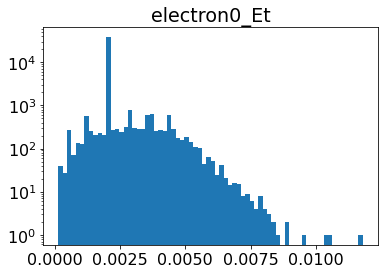

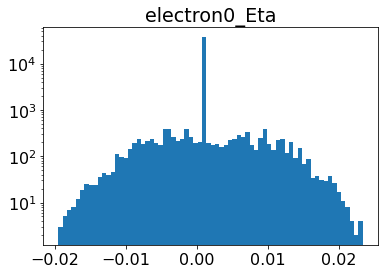

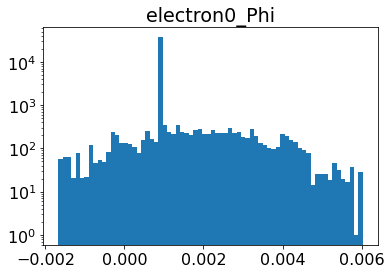

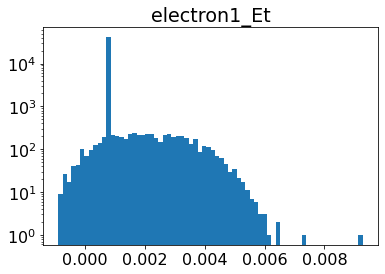

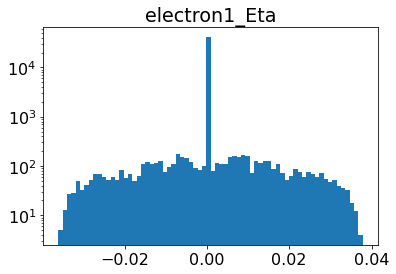

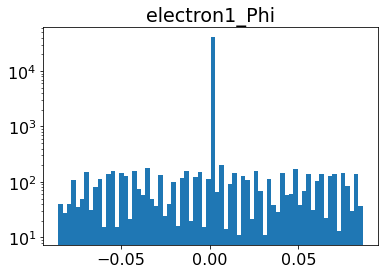

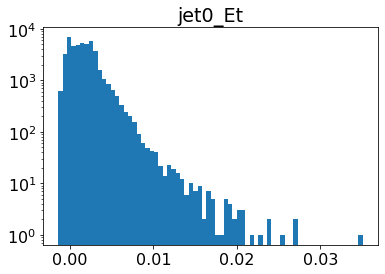

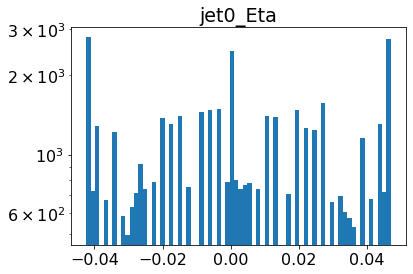

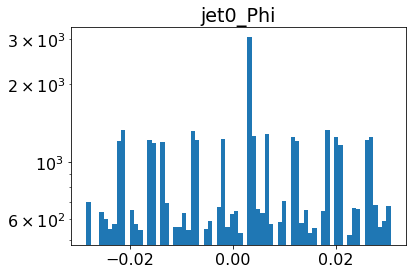

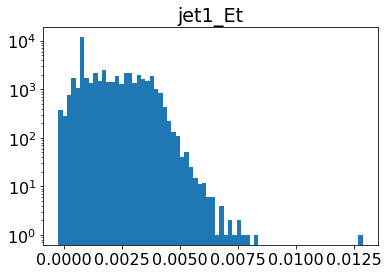

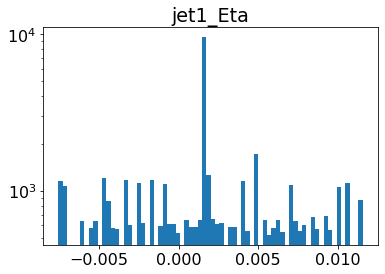

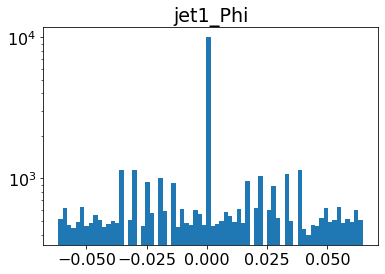

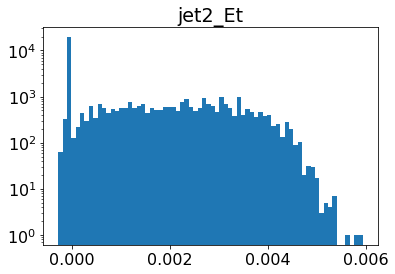

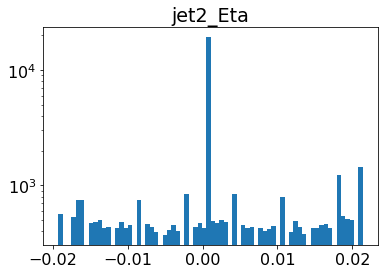

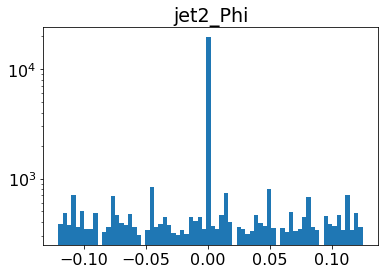

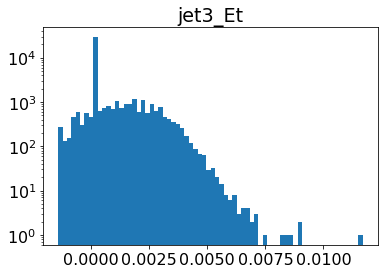

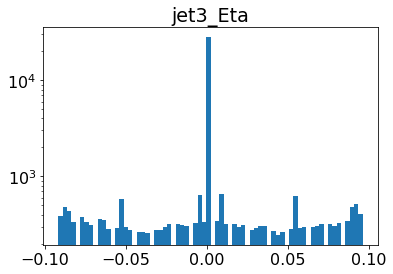

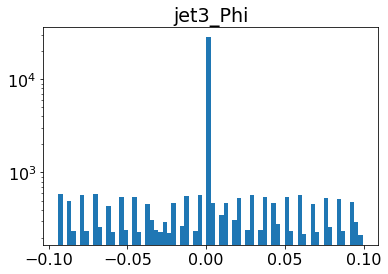

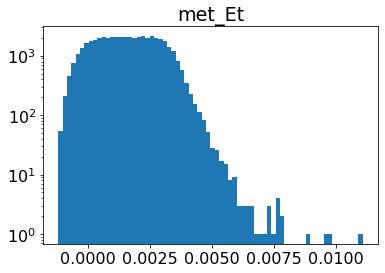

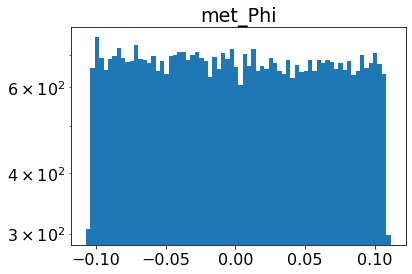

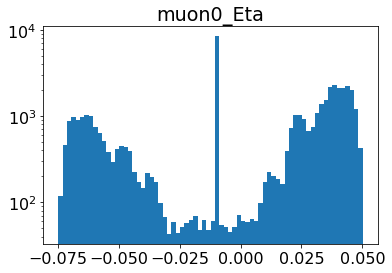

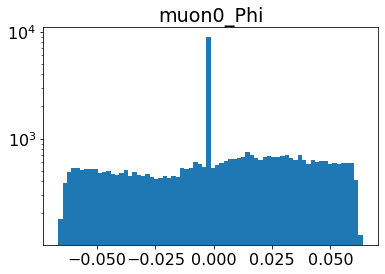

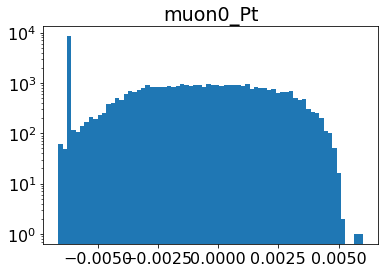

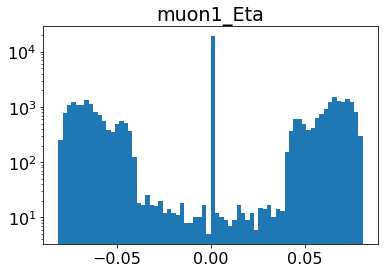

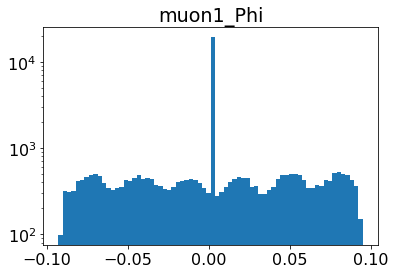

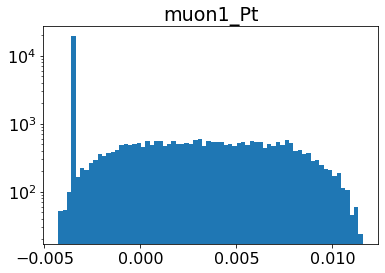

In [134]:
# plot the error distribution and compute its mean and standard deviation
mean_err_avg = np.empty(X_test.shape[1])
mean_err_std = np.empty(X_test.shape[1])


for i in range(26):
    
    Error = X_test[:,i] - X_simulation_scaled[:,i][:len(X_test)]/2**N_frac_bits
    mean_err_avg[i] = np.mean(Error)
    mean_err_std[i] = np.std (Error)

    plt.hist(Error, bins=70)
    
    plt.title(var_names[i])
    plt.semilogy()
    plt.show()

In [135]:
error_stat = np.stack((mean_err_avg,mean_err_std), axis=0)

error_stat_df = pd.DataFrame(data = error_stat,
                             index=["mean", "std"],
                             columns = var_names)

In [136]:
error_stat_df

electron0_Et  electron0_Eta  electron0_Phi  electron1_Et  electron1_Eta  \
mean      0.002336       0.001267       0.001099      0.000956       0.000865   
std       0.000752       0.003652       0.000845      0.000654       0.005858   

      electron1_Phi   jet0_Et  jet0_Eta  jet0_Phi   jet1_Et  ...  jet3_Eta  \
mean       0.002232  0.001725  0.001789  0.002041  0.001928  ...  0.001098   
std        0.016958  0.001922  0.027597  0.016457  0.001228  ...  0.036242   

      jet3_Phi    met_Et   met_Phi  muon0_Eta  muon0_Phi  muon0_Pt  muon1_Eta  \
mean  0.001133  0.001614  0.001151   0.002091   0.001459 -0.001524   0.002014   
std   0.035420  0.001250  0.062004   0.040577   0.032809  0.003119   0.049152   

      muon1_Phi  muon1_Pt  
mean   0.002308  0.000603  
std    0.041424  0.004446  

[2 rows x 26 columns]